# **Exercises**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1LnWFYxWMeakDSzmLLFWM_pjwmtL56gSJ?usp=sharing)

**5.1**

Consider the function $f(x, y) = 3x^2 - 2xy + y^2 + 3e^{-x}$. Is this function convex, concave, or neither? Explain your answer.

In [21]:
import sympy as sp

class ConvexityAnalyzer:
    def __init__(self, function_str, variables_str):
        self.function_str = function_str
        self.variables_str = variables_str
        self.variables = None
        self.f = None
        self.hessian_matrix = None
        self.minor_signs = []

        self._setup()

    def _setup(self):
        try:
            # Create SymPy symbols from the variables string
            self.variables = sp.symbols(self.variables_str)
            if not isinstance(self.variables, tuple):
                self.variables = (self.variables,)
            
            # Sympy-ify the function string
            self.f = sp.sympify(self.function_str)
            print(f"Analyzing function: f({', '.join(map(str, self.variables))}) = {self.f}\n")
        except Exception as e:
            print(f"Error during setup: {e}")
            raise

    def _check_expression_sign(self, expr):
        # 1. Use SymPy's direct checks first
        if expr.is_positive:
            return 'Positive'
        if expr.is_negative:
            return 'Negative'
        if expr.is_nonnegative:
            return 'Non-negative'
        if expr.is_nonpositive:
            return 'Non-positive'

        # 2. Check for perfect even powers (e.g., C * (...)^2)
        coeff, terms = expr.as_coeff_mul()
        if len(terms) == 1 and isinstance(terms[0], sp.Pow):
            base, exponent = terms[0].args
            if isinstance(exponent, sp.Integer) and exponent % 2 == 0:
                if coeff > 0:
                    return 'Non-negative'
                if coeff < 0:
                    return 'Non-positive'
        
        # 3. For expressions with exponential terms, check for a sum of positive parts
        if isinstance(expr, sp.Add):
            all_parts_positive = True
            for arg in expr.args:
                if arg.is_positive:
                    continue
                elif arg.is_Mul:
                    c, f = arg.as_coeff_mul()
                    if c > 0 and (isinstance(f[0], sp.exp) or f[0].is_positive):
                        continue
                all_parts_positive = False
                break
            if all_parts_positive:
                return 'Positive'

        return 'Indefinite'

    def analyze(self):
        if self.f is None or self.variables is None:
            print("Setup failed. Cannot analyze.")
            return

        try:
            # 1. Calculate Gradient and Hessian
            gradient = [sp.diff(self.f, var) for var in self.variables]
            self.hessian_matrix = sp.Matrix([
                [sp.diff(g, var) for var in self.variables] for g in gradient
            ])
            print("--- Hessian Matrix ---")
            sp.pprint(self.hessian_matrix, use_unicode=True)
            print("-" * 50)

            # 2. Analyze the Principal Minors
            print("\n--- Analyzing Principal Minors ---")
            self.minor_signs = []
            for i in range(1, len(self.variables) + 1):
                minor_expr = self.hessian_matrix[:i, :i].det()
                sign = self._check_expression_sign(minor_expr)
                self.minor_signs.append(sign)
                print(f"D{i} = {sp.simplify(minor_expr)}  => Sign: {sign}")

            # 3. Determine Convexity/Concavity
            is_convex = all(s in ['Positive', 'Non-negative'] for s in self.minor_signs)
            if is_convex:
                print("\nConclusion: All principal minors are non-negative.")
                print("The function is CONVEX.")
                return

            is_concave = True
            for i, sign in enumerate(self.minor_signs):
                k = i + 1
                if k % 2 != 0: # D1, D3, ... must be non-positive
                    if sign not in ['Negative', 'Non-positive']:
                        is_concave = False
                        break
                else: # D2, D4, ... must be non-negative
                    if sign not in ['Positive', 'Non-negative']:
                        is_concave = False
                        break
            
            if is_concave:
                print("\nConclusion: Principal minors alternate in sign starting with non-positive.")
                print("The function is CONCAVE.")
                return

            print("\nConclusion: The principal minors do not follow a consistent pattern for convexity or concavity.")
            print("↔The function is NEITHER convex nor concave.")

        except Exception as e:
            print(f"An error occurred during analysis: {e}")

# --- Example Usage ---
if __name__ == "__main__":
    function_input_1 = '3*x**2 - 2*x*y + y**2 + 3*exp(-x)'
    variables_input_1 = 'x,y'
    analyzer_1 = ConvexityAnalyzer(function_input_1, variables_input_1)
    analyzer_1.analyze()
    print("\n" + "="*70 + "\n")

Analyzing function: f(x, y) = 3*x**2 - 2*x*y + y**2 + 3*exp(-x)

--- Hessian Matrix ---
⎡       -x    ⎤
⎢6 + 3⋅ℯ    -2⎥
⎢             ⎥
⎣   -2      2 ⎦
--------------------------------------------------

--- Analyzing Principal Minors ---
D1 = 6 + 3*exp(-x)  => Sign: Positive
D2 = 8 + 6*exp(-x)  => Sign: Positive

Conclusion: All principal minors are non-negative.
The function is CONVEX.




**5.2**

Consider the function $f(x) = x^4 - 8x^3 + 24x^2 - 32x + 16$. Is this function convex, concave, or neither? Explain your answer.

In [ ]:
import sympy as sp

class SingleVariableConvexityAnalyzer:
    def __init__(self, function_str, variable_str='x'):
        self.function_str = function_str
        self.variable_str = variable_str
        self.x = None
        self.f = None
        
        self._setup()

    def _setup(self):
        try:
            # Create SymPy symbol from the variable string
            self.x = sp.symbols(self.variable_str)
            # Sympy-ify the function string
            self.f = sp.sympify(self.function_str)
            print(f"Analyzing the function: f({self.x}) = {self.f}\n")
        except Exception as e:
            print(f"Error during setup: {e}")
            raise

    def analyze(self):
        if self.f is None or self.x is None:
            print("Setup failed. Cannot analyze.")
            return

        try:
            # --- 1. Calculate the First Derivative ---
            f_prime = sp.diff(self.f, self.x)
            print(f"--- Step 1: First Derivative f'({self.x}) ---")
            print(f"f'({self.x}) = {f_prime}")
            print("-" * 50)

            # --- 2. Calculate the Second Derivative ---
            f_double_prime = sp.diff(f_prime, self.x)
            print(f"\n--- Step 2: Second Derivative f''({self.x}) ---")
            f_double_prime_simplified = sp.simplify(f_double_prime)
            f_double_prime_factored = sp.factor(f_double_prime_simplified)
            print(f"f''({self.x}) = {f_double_prime_simplified}")
            if str(f_double_prime_factored) != str(f_double_prime_simplified):
                print(f"Factored f''({self.x}) = {f_double_prime_factored}")
            print("-" * 50)

            # --- 3. Analyze the Sign of the Second Derivative ---
            print(f"\n--- Step 3: Analyzing the sign of f''({self.x}) ---")
            
            conclusion_found = False

            # More Robust Check for Perfect Even Powers
            coeff, terms = f_double_prime_factored.as_coeff_mul()
            if len(terms) == 1 and isinstance(terms[0], sp.Pow):
                base, exponent = terms[0].args
                if isinstance(exponent, sp.Integer) and exponent % 2 == 0:
                    if coeff > 0:
                        print(f"The expression is a positive constant ({coeff}) times a term raised to an even power.")
                        print("\nConclusion: Since f''(x) >= 0 for all x, the function is CONVEX.")
                        conclusion_found = True
                    elif coeff < 0:
                        print(f"The expression is a negative constant ({coeff}) times a term raised to an even power.")
                        print("\nConclusion: Since f''(x) <= 0 for all x, the function is CONCAVE.")
                        conclusion_found = True
            
            # General SymPy Check (Fallback)
            if not conclusion_found:
                if f_double_prime_factored.is_nonnegative:
                    print(f"The expression for f''({self.x}), which is {f_double_prime_factored}, is always greater than or equal to 0.")
                    print("\nConclusion: Since f''(x) >= 0 for all x, the function is CONVEX.")
                elif f_double_prime_factored.is_nonpositive:
                    print(f"The expression for f''({self.x}), which is {f_double_prime_factored}, is always less than or equal to 0.")
                    print("\nConclusion: Since f''(x) <= 0 for all x, the function is CONCAVE.")
                else:
                    try:
                        critical_points = sp.solve(f_double_prime_factored, self.x)
                        print(f"The sign of f''({self.x}) changes. Let's check its roots: {critical_points}")
                        print(f"\nConclusion: Since the sign of f''({self.x}) is not constant, the function is NEITHER convex nor concave.")
                    except Exception as e:
                        print(f"Could not definitively determine the sign of f''({self.x}) for all x. The function is likely NEITHER convex nor concave.")

        except Exception as e:
            print(f"An error occurred during analysis: {e}")
            print("Please check if the function and variable name are entered correctly.")

# --- Example Usage ---
if __name__ == "__main__":
    function_input_1 = 'x**4 - 8*x**3 + 24*x**2 - 32*x + 16'
    analyzer_1 = SingleVariableConvexityAnalyzer(function_input_1)
    analyzer_1.analyze()
    print("\n" + "="*70 + "\n")

Analyzing the function: f(x) = x**4 - 8*x**3 + 24*x**2 - 32*x + 16

--- Step 1: First Derivative f'(x) ---
f'(x) = 4*x**3 - 24*x**2 + 48*x - 32
--------------------------------------------------

--- Step 2: Second Derivative f''(x) ---
f''(x) = 12*x**2 - 48*x + 48
Factored f''(x) = 12*(x - 2)**2
--------------------------------------------------

--- Step 3: Analyzing the sign of f''(x) ---
The expression is a positive constant (12) times a term raised to an even power.

Conclusion: Since f''(x) >= 0 for all x, the function is CONVEX.




**5.3**

Consider the following nonlinear problem. Is the feasible region convex?

$$
\begin{align*}
\text{minimize} \quad & f(x, y) = x - 2xy + 2y \\
\text{subject to} \quad &  x^2 + 3y^2 \leq 10 0 \\  
& 3x + 2y \geq 1 \\
& x, y \geq 0
\end{align*}
$$

In [20]:
import sympy as sp

class FeasibleRegionAnalyzer:
    def __init__(self, constraints_str_list, variables_str):
        self.constraints_str_list = constraints_str_list
        self.variables_str = variables_str
        self.variable_symbols = None
        
        self._setup()

    def _setup(self):
        try:
            self.variable_symbols = sp.symbols(self.variables_str)
            if not isinstance(self.variable_symbols, tuple):
                self.variable_symbols = (self.variable_symbols,)
        except Exception as e:
            print(f"Error during setup: {e}")
            raise

    def _analyze_function_convexity(self, f):
        # Check if the function is linear
        if all(sp.degree(f, var) <= 1 for var in self.variable_symbols) and \
           not any(v1 * v2 in f.as_ordered_terms() for v1 in self.variable_symbols for v2 in self.variable_symbols):
            return 'Linear'
            
        # --- Calculate Hessian ---
        try:
            gradient = [sp.diff(f, var) for var in self.variable_symbols]
            hessian_matrix = sp.Matrix([
                [sp.diff(g, var) for var in self.variable_symbols] for g in gradient
            ])
        except Exception:
            return 'Neither' # Cannot compute Hessian

        # --- Analyze Principal Minors ---
        is_positive_semidefinite = True
        is_negative_semidefinite = True

        for i in range(1, len(self.variable_symbols) + 1):
            minor = hessian_matrix[:i, :i].det()
            
            # Check for positive semi-definiteness (for convexity)
            if not minor.is_nonnegative:
                is_positive_semidefinite = False

            # Check for negative semi-definiteness (for concavity)
            k = i
            if (k % 2 != 0 and not minor.is_nonpositive) or \
               (k % 2 == 0 and not minor.is_nonnegative):
                is_negative_semidefinite = False

        if is_positive_semidefinite:
            return 'Convex'
        if is_negative_semidefinite:
            return 'Concave'
            
        return 'Neither'

    def analyze(self):
        if self.variable_symbols is None:
            print("Setup failed. Cannot analyze.")
            return

        print(f"--- Analyzing Feasible Region Defined by ---")
        for c in self.constraints_str_list:
            print(f"  {c}")
        print("-" * 50)

        is_region_convex = True
        for i, constraint_str in enumerate(self.constraints_str_list):
            print(f"\nAnalyzing Constraint {i+1}: '{constraint_str}'")
            
            # Parse the inequality
            if '<=' in constraint_str:
                parts = constraint_str.split('<=')
                inequality_type = 'leq'
            elif '>=' in constraint_str:
                parts = constraint_str.split('>=')
                inequality_type = 'geq'
            else:
                print("  Error: Constraint must contain '<=' or '>='.")
                is_region_convex = False
                continue

            # Form the function g by moving everything to the left side
            try:
                g_expr = sp.sympify(parts[0]) - sp.sympify(parts[1])
            except Exception as e:
                print(f"  Error parsing constraint: {e}")
                is_region_convex = False
                continue
            
            # Analyze the function g
            analysis = self._analyze_function_convexity(g_expr)
            print(f"  Function g = {g_expr}")
            print(f"  Function g is: {analysis}")

            # Check if the constraint defines a convex set
            constraint_is_convex = False
            if analysis == 'Linear':
                constraint_is_convex = True
                print("  Result: Linear constraints always define a convex set.")
            elif inequality_type == 'leq' and analysis == 'Convex':
                constraint_is_convex = True
                print("  Result: 'g(x) <= 0' with a convex g(x) defines a convex set.")
            elif inequality_type == 'geq' and analysis == 'Concave':
                constraint_is_convex = True
                print("  Result: 'g(x) >= 0' with a concave g(x) defines a convex set.")
            else:
                is_region_convex = False
                print(f"  Result: This constraint defines a NON-CONVEX set.")
        
        print("\n" + "="*50)
        if is_region_convex:
            print("FINAL CONCLUSION: The feasible region is CONVEX because it is an intersection of convex sets.")
        else:
            print("FINAL CONCLUSION: The feasible region is NOT CONVEX because at least one constraint defines a non-convex set.")


# --- Example Usage ---
if __name__ == "__main__":
    constraints_5_3 = [
        'x**2 + 3*y**2 <= 10',
        '3*x + 2*y >= 1',
        'x >= 0',
        'y >= 0'
    ]
    variables_5_3 = 'x,y'
    analyzer_1 = FeasibleRegionAnalyzer(constraints_5_3, variables_5_3)
    analyzer_1.analyze()

--- Analyzing Feasible Region Defined by ---
  x**2 + 3*y**2 <= 10
  3*x + 2*y >= 1
  x >= 0
  y >= 0
--------------------------------------------------

Analyzing Constraint 1: 'x**2 + 3*y**2 <= 10'
  Function g = x**2 + 3*y**2 - 10
  Function g is: Convex
  Result: 'g(x) <= 0' with a convex g(x) defines a convex set.

Analyzing Constraint 2: '3*x + 2*y >= 1'
  Function g = 3*x + 2*y - 1
  Function g is: Linear
  Result: Linear constraints always define a convex set.

Analyzing Constraint 3: 'x >= 0'
  Function g = x
  Function g is: Linear
  Result: Linear constraints always define a convex set.

Analyzing Constraint 4: 'y >= 0'
  Function g = y
  Function g is: Linear
  Result: Linear constraints always define a convex set.

FINAL CONCLUSION: The feasible region is CONVEX because it is an intersection of convex sets.


**5.4**

Consider the following nonlinear problem. Is the feasible region convex?

$$
\begin{align*}
\text{minimize} \quad & f(x, y) = 3x^2 - 2xy + y^2 \\
\text{subject to} \quad &  x^3 - 12x - y \geq 0 \\  
& x \geq 1 
\end{align*}
$$

In [ ]:
import sympy as sp

class FeasibleRegionAnalyzer:
    def __init__(self, constraints_str_list, variables_str):
        self.constraints_str_list = constraints_str_list
        self.variables_str = variables_str
        self.variable_symbols = None
        
        self._setup()

    def _setup(self):
        try:
            self.variable_symbols = sp.symbols(self.variables_str)
            if not isinstance(self.variable_symbols, tuple):
                self.variable_symbols = (self.variable_symbols,)
        except Exception as e:
            print(f"Error during setup: {e}")
            raise

    def _analyze_function_convexity(self, f):
        # Check if the function is linear
        if all(sp.degree(f, var) <= 1 for var in self.variable_symbols) and \
           not any(v1 * v2 in f.as_ordered_terms() for v1 in self.variable_symbols for v2 in self.variable_symbols):
            return 'Linear'
            
        # --- Calculate Hessian ---
        try:
            gradient = [sp.diff(f, var) for var in self.variable_symbols]
            hessian_matrix = sp.Matrix([
                [sp.diff(g, var) for var in self.variable_symbols] for g in gradient
            ])
        except Exception:
            return 'Neither' # Cannot compute Hessian

        # --- Analyze Principal Minors ---
        is_positive_semidefinite = True
        is_negative_semidefinite = True

        for i in range(1, len(self.variable_symbols) + 1):
            minor = hessian_matrix[:i, :i].det()
            
            # Check for positive semi-definiteness (for convexity)
            if not minor.is_nonnegative:
                is_positive_semidefinite = False

            # Check for negative semi-definiteness (for concavity)
            k = i
            if (k % 2 != 0 and not minor.is_nonpositive) or \
               (k % 2 == 0 and not minor.is_nonnegative):
                is_negative_semidefinite = False

        if is_positive_semidefinite:
            return 'Convex'
        if is_negative_semidefinite:
            return 'Concave'
            
        return 'Neither'

    def analyze(self):
        if self.variable_symbols is None:
            print("Setup failed. Cannot analyze.")
            return

        print(f"--- Analyzing Feasible Region Defined by ---")
        for c in self.constraints_str_list:
            print(f"  {c}")
        print("-" * 50)

        is_region_convex = True
        for i, constraint_str in enumerate(self.constraints_str_list):
            print(f"\nAnalyzing Constraint {i+1}: '{constraint_str}'")
            
            # Parse the inequality
            if '<=' in constraint_str:
                parts = constraint_str.split('<=')
                inequality_type = 'leq'
            elif '>=' in constraint_str:
                parts = constraint_str.split('>=')
                inequality_type = 'geq'
            else:
                print("  Error: Constraint must contain '<=' or '>='.")
                is_region_convex = False
                continue

            # Form the function g by moving everything to the left side
            try:
                g_expr = sp.sympify(parts[0]) - sp.sympify(parts[1])
            except Exception as e:
                print(f"  Error parsing constraint: {e}")
                is_region_convex = False
                continue
            
            # Analyze the function g
            analysis = self._analyze_function_convexity(g_expr)
            print(f"  Function g = {g_expr}")
            print(f"  Function g is: {analysis}")

            # Check if the constraint defines a convex set
            constraint_is_convex = False
            if analysis == 'Linear':
                constraint_is_convex = True
                print("  Result: Linear constraints always define a convex set.")
            elif inequality_type == 'leq' and analysis == 'Convex':
                constraint_is_convex = True
                print("  Result: 'g(x) <= 0' with a convex g(x) defines a convex set.")
            elif inequality_type == 'geq' and analysis == 'Concave':
                constraint_is_convex = True
                print("  Result: 'g(x) >= 0' with a concave g(x) defines a convex set.")
            else:
                is_region_convex = False
                print(f"  Result: This constraint defines a NON-CONVEX set.")
        
        print("\n" + "="*50)
        if is_region_convex:
            print("FINAL CONCLUSION: The feasible region is CONVEX because it is an intersection of convex sets.")
        else:
            print("FINAL CONCLUSION: The feasible region is NOT CONVEX because at least one constraint defines a non-convex set.")

# --- Example Usage ---
if __name__ == "__main__":
    constraints_5_4 = [
        'x**3 - 12*x - y >= 0',
        'x >= 1'
    ]
    variables_5_4 = 'x,y'
    analyzer_1 = FeasibleRegionAnalyzer(constraints_5_4, variables_5_4)
    analyzer_1.analyze()

--- Analyzing Feasible Region Defined by ---
  x**3 - 12*x - y >= 0
  x >= 1
--------------------------------------------------

Analyzing Constraint 1: 'x**3 - 12*x - y >= 0'
  Function g = x**3 - 12*x - y
  Function g is: Neither
  Result: This constraint defines a NON-CONVEX set.

Analyzing Constraint 2: 'x >= 1'
  Function g = x - 1
  Function g is: Linear
  Result: Linear constraints always define a convex set.

FINAL CONCLUSION: The feasible region is NOT CONVEX because at least one constraint defines a non-convex set.


**5.5**

Use the one dimensional search described in Section 5.2.1 (also known as a bisection search) to find a minimum of the function

$$f(x) = x^4 - 3x^3 + 2x^2 - 2x + 7$$
$$\text{over the range } 1 \leq x \leq 10 \text{. Use } \epsilon = 0.1$$

In [ ]:
import sympy as sp
import numpy as np

class BisectionSearchAnalyzer:
    def __init__(self, function_str, initial_a, initial_b, tolerance=0.1, variable_str='x'):
        self.function_str = function_str
        self.initial_a = initial_a
        self.initial_b = initial_b
        self.tolerance = tolerance
        self.variable_str = variable_str
        
        self.x = None
        self.f = None
        self.f_prime = None
        self.f_double_prime = None
        self.f_lambda = None
        self.f_prime_lambda = None
        self.f_double_prime_lambda = None

        self._setup()

    def _setup(self):
        try:
            self.x = sp.symbols(self.variable_str)
            self.f = sp.sympify(self.function_str)
            self.f_prime = sp.diff(self.f, self.x)
            self.f_double_prime = sp.diff(self.f_prime, self.x)
            
            # Convert symbolic expressions to numerical functions for evaluation
            self.f_lambda = sp.lambdify(self.x, self.f, 'numpy')
            self.f_prime_lambda = sp.lambdify(self.x, self.f_prime, 'numpy')
            self.f_double_prime_lambda = sp.lambdify(self.x, self.f_double_prime, 'numpy')

            print(f"Given\nf(x) = {self.f},\nf'(x) = {self.f_prime}.\n")
        except Exception as e:
            print(f"Error during setup: {e}")
            raise

    def analyze(self):
        if self.f is None:
            print("Setup failed. Cannot analyze.")
            return

        a = float(self.initial_a)
        b = float(self.initial_b)

        # --- Iteration Loop ---
        while (b - a) > self.tolerance:
            midpoint = (a + b) / 2
            f_prime_m = self.f_prime_lambda(midpoint)
            
            print(f"[{a},{b}], m={midpoint}, f'(m)={f_prime_m:.4f}", end="")

            if f_prime_m > 0:
                print(f" > 0 => b <- m")
                b = midpoint
            elif f_prime_m < 0:
                print(f" < 0 => a <- m")
                a = midpoint
            else: # f_prime_m is exactly 0
                print(" = 0 => Exact minimum found.")
                a, b = midpoint, midpoint
                break
        
        # --- Print Final Results ---
        print(f"\nNow b-a = {b} - {a} = {b-a:.7f} <= {self.tolerance}, so stop.")
        
        final_x = (a + b) / 2
        final_f_value = self.f_lambda(final_x)
        
        print(f"Take x* = (a+b)/2 = {final_x:.7f}.\n")
        print("Answer:")
        print(f"x* ≈ {final_x:.3f},\nf(x*) ≈ {final_f_value:.4f}.\n")

        # --- Confirmation with Second Derivative Test ---
        f_double_prime_val = self.f_double_prime_lambda(final_x)
        print(f"(f''(x) = {self.f_double_prime} gives f''({final_x:.3f}) ≈ {f_double_prime_val:.4f}", end="")
        if f_double_prime_val > 0:
            print(" > 0, confirming a local minimum.")
        elif f_double_prime_val < 0:
            print(" < 0, indicating a local maximum.")
        else:
            print(" = 0, the test is inconclusive.")
            

# --- Example Usage ---
if __name__ == "__main__":
    function = 'x**4 - 3*x**3 + 2*x**2 - 2*x + 7'
    a_val = 1
    b_val = 10
    epsilon_val = 0.1
    
    # Create an instance of the analyzer and run it
    analyzer = BisectionSearchAnalyzer(function, a_val, b_val, tolerance=epsilon_val)
    analyzer.analyze()

Given
f(x) = x**4 - 3*x**3 + 2*x**2 - 2*x + 7,
f'(x) = 4*x**3 - 9*x**2 + 4*x - 2.

[1.0,10.0], m=5.5, f'(m)=413.2500 > 0 => b <- m
[1.0,5.5], m=3.25, f'(m)=53.2500 > 0 => b <- m
[1.0,3.25], m=2.125, f'(m)=4.2422 > 0 => b <- m
[1.0,2.125], m=1.5625, f'(m)=-2.4639 < 0 => a <- m
[1.5625,2.125], m=1.84375, f'(m)=-0.1490 < 0 => a <- m
[1.84375,2.125], m=1.984375, f'(m)=1.7536 > 0 => b <- m
[1.84375,1.984375], m=1.9140625, f'(m)=0.7332 > 0 => b <- m

Now b-a = 1.9140625 - 1.84375 = 0.0703125 <= 0.1, so stop.
Take x* = (a+b)/2 = 1.8789062.

Answer:
x* ≈ 1.879,
f(x*) ≈ 2.8665.

(f''(x) = 12*x**2 - 18*x + 4 gives f''(1.879) ≈ 12.5432 > 0, confirming a local minimum.


**5.6**

The *golden section search* is similar to the bisection search for one dimensional problems, except that it uses only function values and it does not require calculating derivatives. This is particularly useful when the function does not have first derivatives defined, or when computing the first derivatives is very expensive computationally. Suppose you are given two initial end-points, $a \le x \le d$, and the minimum of $f(x)$ is known to lie in this range. Evaluate the function at two points $c = a + 0.618 \cdot [d - a]$, and $b = d - 0.618 \cdot [d - a]$. Note that $a < b < c < d$, but they are not evenly spaced. If $f(b) < f(c)$, then let $[a, c]$ be the new interval, and repeat the calculation. Otherwise, let $[b, d]$ be the new interval. The magic aspect of the golden section is that when you have to compute the new interior points between $[a, c]$, you discover that $b$ is precisely $0.618$ of the distance between $a$ and $c$. In other words, you only need to make one additional function evaluation. Similarly, if the new interval is $[b, d]$, then point $c$ is already lined up with one of the new required points.

Use the method of golden section to find the minimum of the function in the previous problem with $\epsilon = 0.1$.

In [ ]:
import sympy as sp
import numpy as np

class GoldenSectionSearchAnalyzer:
    def __init__(self, function_str, initial_a, initial_d, tolerance=0.1, variable_str='x'):
        self.function_str = function_str
        self.initial_a = initial_a
        self.initial_d = initial_d
        self.tolerance = tolerance
        self.variable_str = variable_str
        
        self.x = None
        self.f = None
        self.f_lambda = None
        
        self._setup()

    def _setup(self):
        try:
            # Golden Ratio constant (phi)
            self.phi = (1 + np.sqrt(5)) / 2
            # We use the inverse (1/phi) for interval reduction
            self.inv_phi = 1 / self.phi
            
            self.x = sp.symbols(self.variable_str)
            self.f = sp.sympify(self.function_str)
            
            # Convert symbolic expression to a numerical function for evaluation
            self.f_lambda = sp.lambdify(self.x, self.f, 'numpy')

            print(f"Using golden-section search on\nf(x) = {self.f} with ε={self.tolerance} (φ⁻¹ ≈ {self.inv_phi:.4f}):\n")
        except Exception as e:
            print(f"Error during setup: {e}")
            raise

    def analyze(self):
        if self.f is None:
            print("Setup failed. Cannot analyze.")
            return

        a = float(self.initial_a)
        d = float(self.initial_d)

        # --- Initialize the first two interior points ---
        length = d - a
        b = d - self.inv_phi * length
        c = a + self.inv_phi * length
        
        f_b = self.f_lambda(b)
        f_c = self.f_lambda(c)

        print("Key intervals (rounded):")
        print(f"[{a:.4f}, {d:.4f}]")

        # --- Iteration Loop ---
        while (d - a) > self.tolerance:
            if f_b < f_c:
                # The new interval is [a, c]
                # d becomes c, c becomes b, and b is the new point
                d = c
                c = b
                f_c = f_b
                length = d - a
                b = d - self.inv_phi * length
                f_b = self.f_lambda(b)
            else: # f_c <= f_b
                # The new interval is [b, d]
                # a becomes b, b becomes c, and c is the new point
                a = b
                b = c
                f_b = f_c
                length = d - a
                c = a + self.inv_phi * length
                f_c = self.f_lambda(c)
            
            print(f"[{a:.4f}, {d:.4f}]")

        # --- Print Final Results ---
        print(f"[{a:.4f}, {d:.4f}]  (final; length ≈ {d-a:.4f} < {self.tolerance})\n")

        # Determine the final estimate for x*
        final_x_centered = (a + d) / 2
        final_f_value = self.f_lambda(final_x_centered)

        print("Result:")
        print(f"x* ≈ {final_x_centered:.3f} (within {self.tolerance}),\nf(x*) ≈ {final_f_value:.4f}.")
            

# --- Example Usage ---
if __name__ == "__main__":
    function = 'x**4 - 3*x**3 + 2*x**2 - 2*x + 7'
    a_val = 1
    d_val = 10
    epsilon_val = 0.1
    
    # Create an instance of the analyzer and run it
    analyzer = GoldenSectionSearchAnalyzer(function, a_val, d_val, tolerance=epsilon_val)
    analyzer.analyze()

Using golden-section search on
f(x) = x**4 - 3*x**3 + 2*x**2 - 2*x + 7 with ε=0.1 (φ⁻¹ ≈ 0.6180):

Key intervals (rounded):
[1.0000, 10.0000]
[1.0000, 6.5623]
[1.0000, 4.4377]
[1.0000, 3.1246]
[1.0000, 2.3131]
[1.5016, 2.3131]
[1.5016, 2.0031]
[1.6931, 2.0031]
[1.8115, 2.0031]
[1.8115, 1.9299]
[1.8115, 1.8847]
[1.8115, 1.8847]  (final; length ≈ 0.0732 < 0.1)

Result:
x* ≈ 1.848 (within 0.1),
f(x*) ≈ 2.8638.


**5.7**

Consider the unconstrained problem:

$$\text{minimize } f(x, y) = 3x^2 - 2xy + y^2 + 3e^{-x}$$

Starting from the solution $(x, y) = (0, 0)$, and an initial step length of 2, perform two iterations of the gradient search algorithm to find a minimum. That is, compute the gradient at the point $(0, 0)$, and perform a one dimensional line search to find a minimum along the line. From this new point, perform a second line search.

In [25]:
import sympy as sp
import numpy as np

class GradientDescentAnalyzer:
    def __init__(self, function_str, initial_point, num_iterations, variables_str='x,y'):
        self.function_str = function_str
        self.initial_point = np.array(initial_point, dtype=float)
        self.num_iterations = num_iterations
        self.variables_str = variables_str
        
        self.variables = None
        self.f = None
        self.grad_f = None
        self.f_lambda = None
        self.grad_f_lambda = None
        
        self._setup()

    def _setup(self):
        try:
            # Define function and variables symbolically
            self.variables = sp.symbols(self.variables_str)
            if not isinstance(self.variables, tuple):
                self.variables = (self.variables,)
            self.f = sp.sympify(self.function_str)

            # Calculate the gradient symbolically
            self.grad_f = sp.Matrix([sp.diff(self.f, var) for var in self.variables])
            
            # Create numerical functions for evaluation
            self.f_lambda = sp.lambdify(self.variables, self.f, 'numpy')
            self.grad_f_lambda = sp.lambdify(self.variables, self.grad_f, 'numpy')

            print(f"Let f({', '.join(map(str, self.variables))}) = {self.f} with")
            print(f"∇f({', '.join(map(str, self.variables))}) = {self.grad_f.T}\n")
        except Exception as e:
            print(f"Error during setup: {e}")
            raise

    def analyze(self):
        if self.f is None:
            print("Setup failed. Cannot analyze.")
            return

        current_point = self.initial_point.copy()
        history = [tuple(current_point)] # Store history for final summary

        # --- Iteration Loop ---
        for i in range(self.num_iterations):
            print("-" * 50)
            print(f"Iteration {i+1} (start at {tuple(current_point)})")

            # --- Calculate Gradient and Search Direction ---
            grad_at_point = self.grad_f_lambda(*current_point).flatten()
            search_direction = -grad_at_point
            
            print(f"∇f({current_point[0]:.4f}, {current_point[1]:.4f}) = ({grad_at_point[0]:.4f}, {grad_at_point[1]:.4f})")
            print(f"  => Steepest-descent direction p_{i} = ({search_direction[0]:.4f}, {search_direction[1]:.4f}).")

            # --- Perform Exact Line Search ---
            alpha = sp.symbols('alpha', real=True, positive=True)
            
            # Define the line: new_point = current_point + alpha * search_direction
            line_point = [current_point[j] + alpha * search_direction[j] for j in range(len(self.variables))]
            
            # Define phi(alpha) = f(line_point)
            phi = self.f.subs(zip(self.variables, line_point))
            phi_prime = sp.diff(phi, alpha)

            print(f"Line: ({self.variables_str}) = ({current_point[0]:.4f}, {current_point[1]:.4f}) + α * ({search_direction[0]:.4f}, {search_direction[1]:.4f})")
            print(f"φ(α) = f(line) = {sp.simplify(phi)}")
            print(f"φ'(α) = {sp.simplify(phi_prime)}")

            # Solve phi'(alpha) = 0 for alpha
            try:
                # nsolve is a numerical solver, good for transcendental equations
                optimal_alpha = sp.nsolve(phi_prime, alpha, 0.1)
            except (ValueError, TypeError):
                # Fallback for simpler (e.g., linear) equations
                optimal_alpha = sp.solve(phi_prime, alpha)[0]

            optimal_alpha = float(optimal_alpha)
            print(f"Set φ'(α)=0 => α_{i+1} ≈ {optimal_alpha:.4f}.")

            # --- Update the point ---
            current_point = current_point + optimal_alpha * search_direction
            history.append(tuple(current_point))
            f_at_new_point = self.f_lambda(*current_point)

            print("New point:")
            print(f"({self.variables[0]}, {self.variables[1]}) = ({current_point[0]:.4f}, {current_point[1]:.4f})")
            print(f"f({current_point[0]:.4f}, {current_point[1]:.4f}) ≈ {f_at_new_point:.4f}")

        print("\n" + "="*50)
        print("Final summary of points:")
        summary_str = " → ".join([f"({p[0]:.4f}, {p[1]:.4f})" for p in history])
        print(summary_str)


# --- Example Usage ---
if __name__ == "__main__":
    function = '3*x**2 - 2*x*y + y**2 + 3*exp(-x)'
    start_point = (0, 0)
    iterations = 2
    
    # Create an instance of the analyzer and run it
    analyzer = GradientDescentAnalyzer(function, start_point, iterations)
    analyzer.analyze()

Let f(x, y) = 3*x**2 - 2*x*y + y**2 + 3*exp(-x) with
∇f(x, y) = Matrix([[6*x - 2*y - 3*exp(-x), -2*x + 2*y]])

--------------------------------------------------
Iteration 1 (start at (np.float64(0.0), np.float64(0.0)))
∇f(0.0000, 0.0000) = (-3.0000, 0.0000)
  => Steepest-descent direction p_0 = (3.0000, -0.0000).
Line: (x,y) = (0.0000, 0.0000) + α * (3.0000, -0.0000)
φ(α) = f(line) = 27.0*alpha**2 + 3*exp(-3.0*alpha)
φ'(α) = 54.0*alpha - 9.0*exp(-3.0*alpha)
Set φ'(α)=0 => α_1 ≈ 0.1172.
New point:
(x, y) = (0.3517, 0.0000)
f(0.3517, 0.0000) ≈ 2.4816
--------------------------------------------------
Iteration 2 (start at (np.float64(0.35173371124919584), np.float64(0.0)))
∇f(0.3517, 0.0000) = (0.0000, -0.7035)
  => Steepest-descent direction p_1 = (-0.0000, 0.7035).
Line: (x,y) = (0.3517, 0.0000) + α * (-0.0000, 0.7035)
φ(α) = f(line) = 0.494866414516531*alpha**2 - 0.494866414516531*alpha + 2.48155207838257
φ'(α) = 0.989732829033061*alpha - 0.494866414516531
Set φ'(α)=0 => α_2 ≈ 0.5000

**5.8**

Repeat Exercise 5.7, but use Newton's method to find the solution.

In [26]:
import sympy as sp
import numpy as np

class NewtonsMethodOptimizer:
    def __init__(self, function_str, initial_point, num_iterations, variables_str):
        self.function_str = function_str
        self.initial_point = np.array(initial_point, dtype=float)
        self.num_iterations = num_iterations
        self.variables_str = variables_str

        self.variables = None
        self.f = None
        self.grad_f = None
        self.hessian_f = None
        self.f_lambda = None
        self.grad_f_lambda = None
        self.hessian_f_lambda = None

        self._setup()

    def _setup(self):
        try:
            # Define function and variables symbolically
            self.variables = sp.symbols(self.variables_str)
            if not isinstance(self.variables, tuple):
                self.variables = (self.variables,)
            
            self.f = sp.sympify(self.function_str)

            if len(self.variables) != len(self.initial_point):
                raise ValueError("The number of variables must match the dimension of the initial point.")

            # Calculate the gradient and Hessian symbolically
            self.grad_f = sp.Matrix([sp.diff(self.f, var) for var in self.variables])
            self.hessian_f = sp.hessian(self.f, self.variables)

            # Create numerical functions for evaluation
            self.f_lambda = sp.lambdify(self.variables, self.f, 'numpy')
            self.grad_f_lambda = sp.lambdify(self.variables, self.grad_f, 'numpy')
            self.hessian_f_lambda = sp.lambdify(self.variables, self.hessian_f, 'numpy')

            var_names_str = ','.join(map(str, self.variables))
            print("First compute gradient and Hessian:\n")
            print(f"∇f({var_names_str}) = {self.grad_f.T.T},")
            print(f"H({var_names_str}) = {self.hessian_f}\n")
            print("Newton step: solve H(x_k) * s_k = ∇f(x_k) and set x_{k+1} = x_k - s_k.\n")
        except Exception as e:
            print(f"Error during setup: {e}")
            raise

    def optimize(self):
        if self.f is None:
            print("Setup failed. Cannot optimize.")
            return
            
        current_point = self.initial_point.copy()
        history = [{'point': tuple(current_point), 'f_val': self.f_lambda(*current_point)}]

        # --- Iteration Loop ---
        for i in range(self.num_iterations):
            print("-" * 50)
            print(f"Iteration {i} (at ({', '.join(map(str, current_point))}))")

            # --- Evaluate Gradient and Hessian at the current point ---
            grad_val = self.grad_f_lambda(*current_point).flatten()
            hessian_val = self.hessian_f_lambda(*current_point)

            print(f"∇f({', '.join([f'{v:.7f}' for v in current_point])}) = \n{np.array2string(grad_val, precision=8)}")
            print(f"H({', '.join([f'{v:.7f}' for v in current_point])}) = \n{np.array2string(hessian_val, precision=8)}\n")

            # --- Solve the Newton system: H * s = g ---
            print("Solve Hs = ∇f:")
            # Use numpy's linear algebra solver
            step_s = np.linalg.solve(hessian_val, grad_val)
            print(f"s = \n{np.array2string(step_s, precision=8)}\n")

            # --- Update the point ---
            new_point = current_point - step_s
            f_at_new_point = self.f_lambda(*new_point)
            history.append({'point': tuple(new_point), 'f_val': f_at_new_point})

            print("Update:")
            print(f"x_{i+1} = ({', '.join([f'{v:.7f}' for v in current_point])}) - ({', '.join([f'{v:.7f}' for v in step_s])})")
            print(f"x_{i+1} = ({', '.join([f'{v:.7f}' for v in new_point])})\n")
            print(f"Function value: f(x_{i+1}) ≈ {f_at_new_point}")
            
            current_point = new_point

        # --- 3. Final Summary ---
        print("\n" + "="*50)
        print("Summary")
        path_str = " → ".join([f"({', '.join([f'{v:.7f}' for v in item['point']])})" for item in history])
        print(path_str)
        
        f_values_str = ", ".join([f"f(x_{i})≈{item['f_val']:.5f}" for i, item in enumerate(history)])
        print(f_values_str)

# --- Example Usage ---
if __name__ == "__main__":
    function = '3*x**2 - 2*x*y + y**2 + 3*exp(-x)'
    start_point = (0, 0)
    iterations = 2
    variables = 'x,y'
    
    # Create an instance of the optimizer and run it
    optimizer = NewtonsMethodOptimizer(function, start_point, iterations, variables)
    optimizer.optimize()

First compute gradient and Hessian:

∇f(x,y) = Matrix([[6*x - 2*y - 3*exp(-x)], [-2*x + 2*y]]),
H(x,y) = Matrix([[6 + 3*exp(-x), -2], [-2, 2]])

Newton step: solve H(x_k) * s_k = ∇f(x_k) and set x_{k+1} = x_k - s_k.

--------------------------------------------------
Iteration 0 (at (0.0, 0.0))
∇f(0.0000000, 0.0000000) = 
[-3.  0.]
H(0.0000000, 0.0000000) = 
[[ 9. -2.]
 [-2.  2.]]

Solve Hs = ∇f:
s = 
[-0.42857143 -0.42857143]

Update:
x_1 = (0.0000000, 0.0000000) - (-0.4285714, -0.4285714)
x_1 = (0.4285714, 0.4285714)

Function value: f(x_1) ≈ 2.321664111368677
--------------------------------------------------
Iteration 1 (at (0.4285714285714286, 0.42857142857142855))
∇f(0.4285714, 0.4285714) = 
[-2.40031458e-01 -1.11022302e-16]
H(0.4285714, 0.4285714) = 
[[ 7.95431717 -2.        ]
 [-2.          2.        ]]

Solve Hs = ∇f:
s = 
[-0.04031217 -0.04031217]

Update:
x_2 = (0.4285714, 0.4285714) - (-0.0403122, -0.0403122)
x_2 = (0.4688836, 0.4688836)

Function value: f(x_2) ≈ 2.31680489

**5.9**

*Rosenbrock's function* is a particularly difficult problem that looks deceptively simple. Consider the unconstrained function:

$$\text{minimize } f(x, y) = 100 (y - x^2)^2 + (1 - x)^2$$

The function has a unique minimum at the point $(1, 1)$ (where $f(1, 1) = 0$). This pathological example has also been called the *banana function*. If you plot the function, it follows a narrow banana-shaped valley from the point $(-1, 1)$ to the minimum $(1, 1)$. Because the valley has quite steep sides, anytime an algorithm tries to follow the downward slope in a straight line, the line almost immediately starts going up, resulting in very short steps. It is very difficult for any algorithm to find the way around the banana.

Try using both a gradient search and Newton's method beginning at the point $(-1, 1)$. Perform several iterations. You will likely observe rather poor progress along a narrow zig-zag path.


--- Gradient Descent Iterations ---
   iter    x    y  f(x,y)  ||grad||
0     0 -1.0  1.0     4.0       4.0
1     1  1.0  1.0     0.0       0.0
2     2  1.0  1.0     0.0       0.0

Gradient Descent final point: [1. 1.] f= 0.0


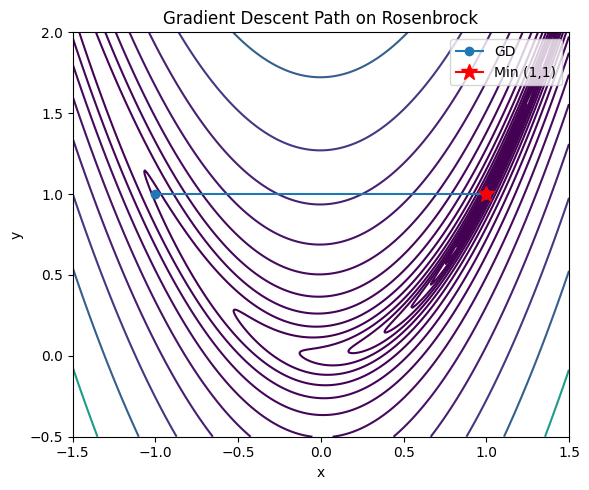


--- Newton's Method Iterations ---
    iter         x         y        f(x,y)      ||grad||
0      0 -1.000000  1.000000  4.000000e+00  4.000000e+00
1      1 -0.750000  0.500000  3.453125e+00  2.552082e+01
2      2 -0.620370  0.368056  2.653837e+00  8.137045e+00
3      3 -0.434581  0.145941  2.242232e+00  1.343103e+01
4      4 -0.284895  0.058759  1.701157e+00  6.806417e+00
5      5 -0.050475 -0.052405  1.405476e+00  1.144980e+01
6      6  0.037134 -0.006296  9.330027e-01  2.374613e+00
7      7  0.227043  0.011645  7.566895e-01  8.246747e+00
8      8  0.313112  0.090631  4.773026e-01  1.547246e+00
9      9  0.451509  0.181003  3.530896e-01  5.485196e+00
10    10  0.549954  0.292758  2.119334e-01  2.296592e+00
11    11  0.703121  0.470919  1.431744e-01  7.620157e+00
12    12  0.755278  0.567725  6.062884e-02  6.375876e-01
13    13  0.834524  0.688790  3.321946e-02  2.694504e+00
14    14  0.899981  0.805681  1.183966e-02  1.592606e+00
15    15  0.953843  0.906916  2.972110e-03  1.168791

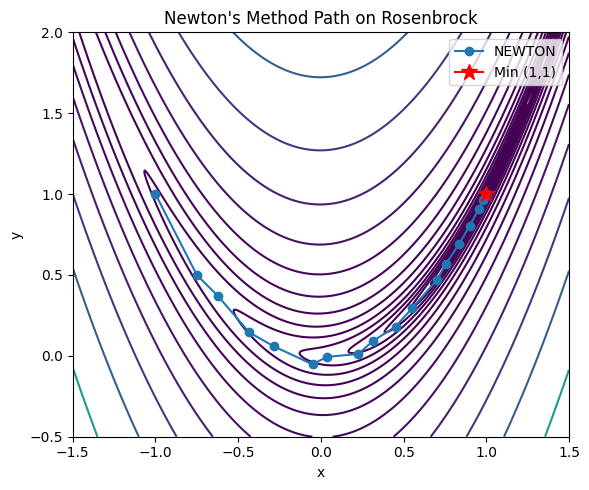

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# General Optimizer Class
# -----------------------------
class Optimizer:
    def __init__(self, func, grad, hess=None, method="gd", tol=1e-10, max_iter=100, c=1e-4, rho=0.5):
        self.func = func
        self.grad = grad
        self.hess = hess
        self.method = method
        self.tol = tol
        self.max_iter = max_iter
        self.c = c
        self.rho = rho

    def backtracking(self, x, p, g):
        alpha = 1.0
        fx = self.func(x)
        while self.func(x + alpha * p) > fx + self.c * alpha * np.dot(g, p):
            alpha *= self.rho
            if alpha < 1e-12:
                break
        return alpha

    def step_direction(self, x, g):
        if self.method == "gd":
            return -g
        elif self.method == "newton":
            try:
                return np.linalg.solve(self.hess(x), -g)
            except np.linalg.LinAlgError:
                # Add damping if Hessian is singular or ill-conditioned
                lam = 1e-4
                return np.linalg.solve(self.hess(x) + lam * np.eye(len(x)), -g)
        else:
            raise ValueError("Unknown method. Use 'gd' or 'newton'.")

    def optimize(self, x0):
        x = np.array(x0, dtype=float)
        log = []
        for k in range(self.max_iter):
            fx = self.func(x)
            g = self.grad(x)
            grad_norm = np.linalg.norm(g)
            log.append((k, x[0], x[1], fx, grad_norm))
            if grad_norm < self.tol:
                break
            p = self.step_direction(x, g)
            alpha = self.backtracking(x, p, g)
            x = x + alpha * p
        # Append final iteration
        log.append((k + 1, x[0], x[1], self.func(x), np.linalg.norm(self.grad(x))))
        df = pd.DataFrame(log, columns=["iter", "x", "y", "f(x,y)", "||grad||"])
        return df, x

    def plot_path(self, traj_df, title="Optimization Path", levels=np.logspace(-2, 3, 20)):
        x_vals = np.linspace(-1.5, 1.5, 400)
        y_vals = np.linspace(-0.5, 2.0, 400)
        X, Y = np.meshgrid(x_vals, y_vals)
        Z = np.array([self.func([x, y]) for x, y in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

        plt.figure(figsize=(6, 5))
        plt.contour(X, Y, Z, levels=levels)
        plt.plot(traj_df["x"], traj_df["y"], marker="o", linestyle="-", label=self.method.upper())
        plt.plot([1], [1], marker="*", markersize=12, color="red", label="Min (1,1)")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Rosenbrock Function Setup
# -----------------------------
def rosenbrock_func(x):
    x1, x2 = x
    return 100 * (x2 - x1 ** 2) ** 2 + (1 - x1) ** 2

def rosenbrock_grad(x):
    x1, x2 = x
    return np.array([
        -400 * x1 * (x2 - x1 ** 2) + 2 * (x1 - 1),
        200 * (x2 - x1 ** 2)
    ])

def rosenbrock_hess(x):
    x1, x2 = x
    return np.array([
        [1200 * x1 ** 2 - 400 * x2 + 2, -400 * x1],
        [-400 * x1, 200]
    ])

# Run Optimization
# -----------------------------
x0 = [-1, 1]

# Gradient Descent
gd_optimizer = Optimizer(func=rosenbrock_func, grad=rosenbrock_grad, hess=rosenbrock_hess, method="gd")
gd_log, gd_final = gd_optimizer.optimize(x0)
print("\n--- Gradient Descent Iterations ---")
print(gd_log)
print("\nGradient Descent final point:", gd_final, "f=", rosenbrock_func(gd_final))
gd_optimizer.plot_path(gd_log, title="Gradient Descent Path on Rosenbrock")

# Newton's Method
newton_optimizer = Optimizer(func=rosenbrock_func, grad=rosenbrock_grad, hess=rosenbrock_hess, method="newton")
newton_log, newton_final = newton_optimizer.optimize(x0)
print("\n--- Newton's Method Iterations ---")
print(newton_log)
print("\nNewton Method final point:", newton_final, "f=", rosenbrock_func(newton_final))
newton_optimizer.plot_path(newton_log, title="Newton's Method Path on Rosenbrock")

**5.10**

Consider the problem:

$$
\begin{align*}
\text{minimize} \quad & f(x, y) = x^2y \\
\text{subject to} \quad &  x^2 + y^2 = 1 
\end{align*}
$$

Use the method of Lagrange multipliers to express this problem as an unconstrained minimization problem, and solve the problem using both the gradient method and Newton's method.

In [39]:
import sympy as sp
import numpy as np
from scipy.optimize import minimize_scalar

class LagrangeOptimizer:
    def __init__(self, f_str, h_str, initial_points, variables_str='x,y', lambda_str='lambda'):
        self.f_str = f_str
        self.h_str = h_str
        self.initial_points = initial_points
        self.variables_str = variables_str
        self.lambda_str = lambda_str

        self.all_vars = None
        self.f = None
        self.h = None
        self.L = None
        self.g = None
        self.J = None
        self.g_lambda = None
        self.J_lambda = None

        self._setup()

    def _setup(self):
        try:
            self.variables = sp.symbols(self.variables_str)
            if not isinstance(self.variables, tuple):
                self.variables = (self.variables,)
            self.lam = sp.symbols(self.lambda_str)
            self.all_vars = self.variables + (self.lam,)

            self.f = sp.sympify(self.f_str)
            self.h = sp.sympify(self.h_str)
            self.L = self.f + self.lam * self.h
            self.g = sp.Matrix([sp.diff(self.L, var) for var in self.all_vars])
            self.J = self.g.jacobian(self.all_vars)

            # Create numerical functions for evaluation
            self.g_lambda = sp.lambdify(self.all_vars, self.g, 'numpy')
            self.J_lambda = sp.lambdify(self.all_vars, self.J, 'numpy')

        except Exception as e:
            print(f"Error during setup: {e}")
            raise

    def _run_newtons_method(self, num_iterations):
        v_k = np.array(self.initial_points['newton'], dtype=float)
        history = [v_k]
        
        phi_norm = lambda v: 0.5 * np.sum(self.g_lambda(*v)**2)

        print("-- Newton's Method --")
        print(f"Start v^(0) = {tuple(v_k)}")

        for i in range(num_iterations):
            g_val = self.g_lambda(*v_k).flatten()
            J_val = self.J_lambda(*v_k)
            
            try:
                s_k = np.linalg.solve(J_val, g_val)
            except np.linalg.LinAlgError:
                print("Warning: Jacobian is singular. Newton's method cannot proceed.")
                break

            alpha = 1.0
            while phi_norm(v_k - alpha * s_k) >= phi_norm(v_k):
                alpha *= 0.5
                if alpha < 1e-8:
                    break
            
            v_k = v_k - alpha * s_k
            history.append(v_k)
            print(f"v^({i+1}) ≈ ({v_k[0]:.8f}, {v_k[1]:.8f}, {v_k[2]:.8f})")
        
        print("Result: Converges quadratically to the analytical solution for the minimum.")
        return history

    def _run_gradient_descent(self, num_iterations):
        v_k = np.array(self.initial_points['gradient'], dtype=float)
        history = [v_k]
        
        phi_lambda = lambda v: 0.5 * np.sum(self.g_lambda(*v)**2)
        grad_phi_lambda = lambda v: self.J_lambda(*v).T @ self.g_lambda(*v)

        print("-- Gradient Descent on Φ = 0.5 * ||g||^2 --")
        print(f"Start v^(0) = {tuple(v_k)}")

        for i in range(num_iterations):
            grad_val = grad_phi_lambda(v_k).flatten()
            search_direction = -grad_val
            
            line_search_func = lambda alpha: phi_lambda(v_k + alpha * search_direction)
            res = minimize_scalar(line_search_func, bounds=(0, 1.0), method='bounded')
            
            v_k = v_k + res.x * search_direction
            history.append(v_k)
            print(f"v^({i+1}) ≈ ({v_k[0]:.4f}, {v_k[1]:.4f}, {v_k[2]:.4f})")
        
        print("Result: Converges slowly towards the analytical solution for the maximum.")
        return history

    def solve(self, num_newton_iter=4, num_gradient_iter=4):
        print("Problem: Minimize f(x,y) subject to h(x,y)=0")
        print(f"f(x,y) = {self.f}")
        print(f"h(x,y) = {self.h} = 0\n")
        
        # --- 1. Analytical Solution ---
        print("--- 1. Analytical Solution ---")
        print(f"The Lagrangian is L(x,y,{self.lam}) = {self.L}\n")
        print("The stationarity conditions (∇L = 0) form the system g(v) = 0:")
        for i, var in enumerate(self.all_vars):
            print(f"  g_{i+1}: {self.g[i]} = 0")
        
        solutions = sp.solve(self.g, self.all_vars, dict=True)
        print("\nSymbolic solver found the following stationary points:")
        min_val, max_val = float('inf'), float('-inf')
        for sol in solutions:
            point = tuple(v.evalf() for v in sol.values())
            f_val = self.f.subs(sol).evalf()
            print(f"  Point (x, y, λ) ≈ ({point[0]:.6f}, {point[1]:.6f}, {point[2]:.6f}) with f(x,y) ≈ {f_val:.6f}")
            if f_val < min_val: min_val = f_val
            if f_val > max_val: max_val = f_val
        
        print(f"\nAnalytical Minimum f_min ≈ {min_val:.6f}")
        print(f"Analytical Maximum f_max ≈ {max_val:.6f}")

        # --- 2. Numerical Solutions ---
        print("\n\n--- 2. Numerical Solutions ---")
        self._run_newtons_method(num_newton_iter)
        print("\n" + "-" * 20)
        self._run_gradient_descent(num_gradient_iter)


# --- Example Usage ---
if __name__ == "__main__":
    objective_function = 'x**2 * y'
    constraint_function = 'x**2 + y**2 - 1'
    
    start_points = {
        'newton': (0.8, -0.5, 0.0),  
        'gradient': (0.8, 0.5, 0.0) 
    }
    
    # Create an instance of the optimizer and run it
    optimizer = LagrangeOptimizer(objective_function, constraint_function, start_points, lambda_str='L')
    optimizer.solve()

Problem: Minimize f(x,y) subject to h(x,y)=0
f(x,y) = x**2*y
h(x,y) = x**2 + y**2 - 1 = 0

--- 1. Analytical Solution ---
The Lagrangian is L(x,y,L) = L*(x**2 + y**2 - 1) + x**2*y

The stationarity conditions (∇L = 0) form the system g(v) = 0:
  g_1: 2*L*x + 2*x*y = 0
  g_2: 2*L*y + x**2 = 0
  g_3: x**2 + y**2 - 1 = 0

Symbolic solver found the following stationary points:
  Point (x, y, λ) ≈ (0.000000, 0.000000, -1.000000) with f(x,y) ≈ 0.000000
  Point (x, y, λ) ≈ (0.000000, 0.000000, 1.000000) with f(x,y) ≈ 0.000000
  Point (x, y, λ) ≈ (-0.577350, -0.816497, 0.577350) with f(x,y) ≈ 0.384900
  Point (x, y, λ) ≈ (-0.577350, 0.816497, 0.577350) with f(x,y) ≈ 0.384900
  Point (x, y, λ) ≈ (0.577350, -0.816497, -0.577350) with f(x,y) ≈ -0.384900
  Point (x, y, λ) ≈ (0.577350, 0.816497, -0.577350) with f(x,y) ≈ -0.384900

Analytical Minimum f_min ≈ -0.384900
Analytical Maximum f_max ≈ 0.384900


--- 2. Numerical Solutions ---
-- Newton's Method --
Start v^(0) = (np.float64(0.8), np.float64

**5.11**

Consider the following nonlinear problem with linear constraints:

$$
\begin{align*}
\text{maximize} \quad & f(x, y) = x^2y + 2y^2 \\
\text{subject to} \quad &  x + 3y \leq 9 \\  
& x + 2y \leq 8 \\
& 3x + 2y \leq 18 \\
& 0 \leq x \leq 5 \\
&  0 \leq y \leq 2
\end{align*}
$$

Solve this problem graphically. Begin at the point $(0, 0)$, and check the gradient. If the Karush-Kuhn-Tucker conditions are not satisfied, you should be able to find an improving direction in the feasible region.

Feasible vertices and objective values:
(0.0, 0.0) -> f(x,y) = 0.0000
(-0.0, 2.0) -> f(x,y) = 8.0000
(3.0, 2.0) -> f(x,y) = 26.0000
(5.0, -0.0) -> f(x,y) = 0.0000
(5.0, 1.3333333333333333) -> f(x,y) = 36.8889

Maximum occurs at (5.0, 1.3333333333333333) with f_max = 36.8889


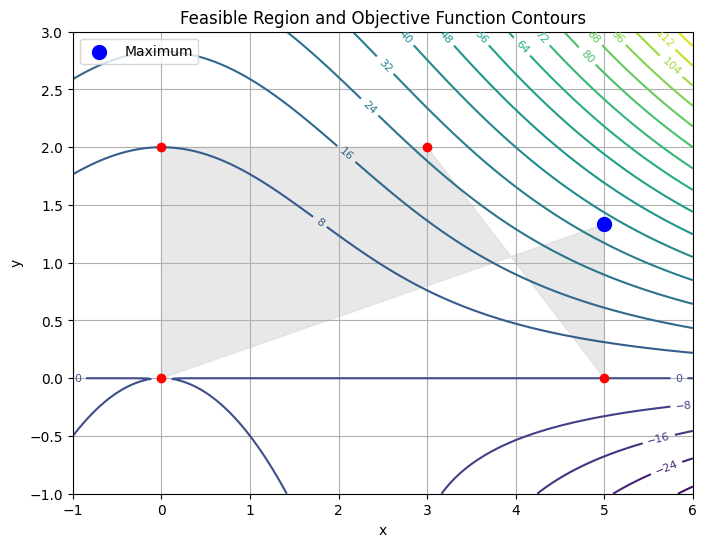

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.patches import Polygon

class LinearProgramSolver:
    def __init__(self, obj_func, constraints_list, x_bounds=(None, None), y_bounds=(None, None)):
        self.obj_func = obj_func
        self.constraints_list = constraints_list
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds
        self.all_constraints = self._get_all_constraints()
        self.feasible_vertices = []
        self.optimal_vertex = None
        self.optimal_value = -np.inf

    def _get_all_constraints(self):
        constraints = self.constraints_list[:]
        
        # Add bounds as constraints
        if self.x_bounds[0] is not None:
            constraints.append((-1, 0, -self.x_bounds[0])) # -x <= -x_min -> x >= x_min
        if self.x_bounds[1] is not None:
            constraints.append((1, 0, self.x_bounds[1]))  # x <= x_max
        if self.y_bounds[0] is not None:
            constraints.append((0, -1, -self.y_bounds[0])) # -y <= -y_min -> y >= y_min
        if self.y_bounds[1] is not None:
            constraints.append((0, 1, self.y_bounds[1]))  # y <= y_max
            
        return constraints

    def _intersection(self, c1, c2):
        a1, b1, c1_val = c1
        a2, b2, c2_val = c2
        det = a1 * b2 - a2 * b1
        if np.isclose(det, 0):
            return None
        x = (c1_val * b2 - c2_val * b1) / det
        y = (a1 * c2_val - a2 * c1_val) / det
        return (x, y)

    def _is_feasible(self, point):
        x, y = point
        for a, b, c_val in self.all_constraints:
            if (a * x + b * y - c_val) > 1e-6:
                return False
        return True

    def solve(self, verbose=True):
        # Generate feasible vertices
        vertices = []
        for c1, c2 in combinations(self.all_constraints, 2):
            pt = self._intersection(c1, c2)
            if pt is not None:
                x, y = pt
                # Check if point satisfies all constraints
                feasible = True
                for a, b, c_val in self.all_constraints:
                    if a*x + b*y - c_val > 1e-6:
                        feasible = False
                        break
                if feasible:
                    vertices.append((x, y))

        # Remove duplicates and sort for consistent output
        unique_vertices = []
        for v in vertices:
            is_new = True
            for uv in unique_vertices:
                if np.allclose(v, uv):
                    is_new = False
                    break
            if is_new:
                unique_vertices.append(v)
        
        # Sort the vertices to ensure consistent output order
        self.feasible_vertices = sorted(unique_vertices, key=lambda p: (p[0], p[1]))

        # Evaluate objective at vertices
        values = [self.obj_func(v[0], v[1]) for v in self.feasible_vertices]
        
        if not values:
            if verbose:
                print("No feasible region found.")
            return

        max_idx = np.argmax(values)
        self.optimal_vertex = self.feasible_vertices[max_idx]
        self.optimal_value = values[max_idx]

        if verbose:
            print("Feasible vertices and objective values:")
            for v, val in zip(self.feasible_vertices, values):
                print(f"{v} -> f(x,y) = {val:.4f}")
            print(f"\nMaximum occurs at {self.optimal_vertex} with f_max = {self.optimal_value:.4f}")
        
        return self.optimal_vertex, self.optimal_value

    def plot_solution(self):
        if not self.feasible_vertices:
            print("Cannot plot: No feasible region found.")
            return

        # Use the provided bounds as the basis for the plot limits and add padding
        x_min = self.x_bounds[0] if self.x_bounds[0] is not None else min(v[0] for v in self.feasible_vertices)
        x_max = self.x_bounds[1] if self.x_bounds[1] is not None else max(v[0] for v in self.feasible_vertices)
        y_min = self.y_bounds[0] if self.y_bounds[0] is not None else min(v[1] for v in self.feasible_vertices)
        y_max = self.y_bounds[1] if self.y_bounds[1] is not None else max(v[1] for v in self.feasible_vertices)

        # Add a fixed padding to the bounds to ensure all lines and intersections are visible
        padding = 1.0
        plot_x_min = x_min - padding
        plot_x_max = x_max + padding
        plot_y_min = y_min - padding
        plot_y_max = y_max + padding

        x = np.linspace(plot_x_min, plot_x_max, 400)
        y = np.linspace(plot_y_min, plot_y_max, 400)
        X, Y = np.meshgrid(x, y)
        Z = self.obj_func(X, Y)

        plt.figure(figsize=(8, 6))
        contours = plt.contour(X, Y, Z, levels=20, cmap='viridis')
        plt.clabel(contours, inline=True, fontsize=8)

        # Plot feasible region as polygon
        polygon = Polygon(self.feasible_vertices, closed=True, fill=True, color='lightgrey', alpha=0.5)
        plt.gca().add_patch(polygon)

        # Plot vertices and optimal point
        vx, vy = zip(*self.feasible_vertices)
        plt.scatter(vx, vy, color='red', zorder=2)
        plt.scatter([self.optimal_vertex[0]], [self.optimal_vertex[1]], color='blue', s=100, zorder=3, label='Maximum')

        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Feasible Region and Objective Function Contours')
        plt.legend()
        plt.xlim(plot_x_min, plot_x_max)
        plt.ylim(plot_y_min, plot_y_max)
        plt.grid(True)
        plt.show()

# Example usage:
# -----------------------------
if __name__ == "__main__":
    def objective_function(x, y):
        return x**2 * y + 2*y**2

    # Constraints for the example problem
    constraints = [
        (1, 3, 9),      # x + 3y <= 9
        (1, 2, 8),      # x + 2y <= 8
        (3, 2, 18),     # 3x + 2y <= 18
    ]

    # Variable bounds
    x_bounds = (0, 5)
    y_bounds = (0, 2)

    # Create the solver instance
    solver = LinearProgramSolver(objective_function, constraints, x_bounds, y_bounds)

    # Solve the problem
    optimal_vertex, optimal_value = solver.solve()
    
    # Plot the solution
    solver.plot_solution()